## Plot Gene and Peak Coverage

`radar` conda env

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
suppressMessages(suppressWarnings(library (RADAR)))
suppressMessages(suppressWarnings(library (patchwork)))

In [3]:
%%R
radar0 <- readRDS('radar/finalObj.rds')

In [4]:
%%R
radar <- PrepCoveragePlot(radar0)

In [5]:
%%R 
summary(radar)

MeRIP.RADAR dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
         U1    U2    T1    T2
Input 29.95 37.35 33.16 29.93
IP    38.34 36.35 43.09 44.55
Input gene level read count available.
There are 1 predictor variables/covariates. Can access by function variable(MeRIPdata). 
Differential methylation tested by PoissonGamma test (RADAR).
Multiple test corrected by Benjamini & Hochberg.


In [47]:
# %%R 
# plot_target_gene <- function(radar,gene_id,gene_name,start,end,peak_start,peak_end){

#     p1 = plotGeneCov(
#         radar,geneName = gene_id,
#         center = mean, libraryType = "opposite",
#         ZoomIn = c(start,end), adjustExprLevel = T
#     ) + ggtitle(gene_name)

#     p1 <- p1 + theme(
#         axis.text.x = element_text(angle = 30, vjust = 1,hjust=1),
#         legend.position = "none"
#     )
    
#     p2 = plotGeneCov(
#         radar,geneName = gene_id,
#         center = mean, libraryType = "opposite",
#         ZoomIn = c(
#             peak_start, # + 
#             peak_end    # -
#         ), adjustExprLevel = T
#     )
#     p2 <- p2 + theme_minimal()
    
#     return(p1 + p2)
# }

In [7]:
!cat radar/result.sig.bed | grep "end\|ENSG00000104549.12\|ENSG00000185085.2" > target-genes-sig-peaks.bed

In [8]:
!cat target-genes-sig-peaks.bed | awk -F "\t" '{print $4"\t"$2"-"$3}'

name	start-end
ENSG00000104549.12	124999289-124999338
ENSG00000185085.2	62647794-62647843
ENSG00000185085.2	62649635-62649684


### [SQLE](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SQLE)
chr8:124,998,497-125,022,283(GRCh38/hg38)

In [128]:
# %%R
# p_sqle = plot_target_gene(
#     radar,"ENSG00000104549.12",'SQLE',
#     start=124998497,end=125022283,
#     peak_start=124999289,
#     peak_end=124999338
# )

In [24]:
%%R
p1 <- plotGeneCov(
    radar,geneName = "ENSG00000104549.12", # SQLE
    center = mean, libraryType = "opposite",
    ZoomIn = c(124998497,125022283), adjustExprLevel = T
    #, split = T
) 

In [35]:
%%R 
p1 <- p1 + ggtitle('SQLE') + theme_classic() + theme(
    legend.position = "none",
    axis.text.x = element_text(angle = 30, vjust = 1,hjust=1)
)

In [48]:
%%R
p2 = plotGeneCov(
    radar,geneName = "ENSG00000104549.12", # SQLE
    center = mean, libraryType = "opposite",
    ZoomIn = c(
        124999289,
        124999338 + 40
    ), adjustExprLevel = T
    #, split = T
)

In [49]:
%%R
p2 <- p2 + ggtitle('SQLE peak') + theme_classic() + theme(
    axis.text.x = element_text(angle = 30, vjust = 1,hjust=1)
)

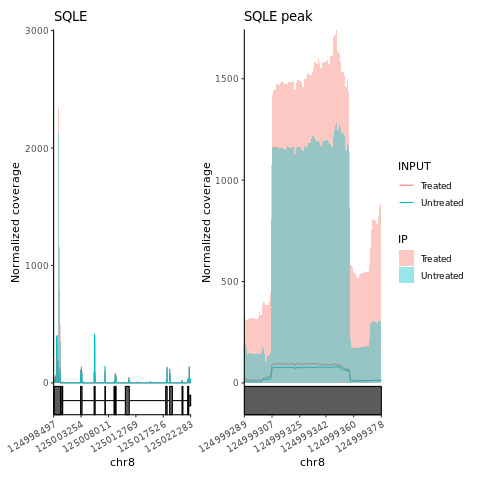

In [50]:
%%R 
p_sqle <- p1 + p2
p_sqle

In [51]:
%%R 
ggsave('SQLE.pdf',p_sqle,width=25,height=5)

### [INTS5](https://www.genecards.org/cgi-bin/carddisp.pl?gene=INTS5)
chr11:62,646,848-62,653,302(GRCh38/hg38)

In [ ]:
# %%R
# p_ints5 = plot_target_gene(
#     radar,"ENSG00000185085.2",'INTS5',
#     start=62646848,end=62653302,
#     peak_start=62649635,
#     peak_end=62649684
# )

In [52]:
%%R
p3 = plotGeneCov(
    radar,geneName = "ENSG00000185085.2", # 
    center = mean, libraryType = "opposite",
    ZoomIn = c(62646848,62653302), adjustExprLevel = T
    #, split = T
)

In [53]:
%%R 
p3 <- p3 + ggtitle('INTS5') + theme(
    axis.text.x = element_text(angle = 30, vjust = 1,hjust=1),
    legend.position = "none"
)

In [57]:
%%R
p4 = plotGeneCov(
    radar,geneName = "ENSG00000185085.2", # INTS5
    center = mean, libraryType = "opposite",
    ZoomIn = c(
        62649635 - 30,
        62649684
    ), adjustExprLevel = T
    #, split = T
)

In [58]:
%%R 
p4 <- p4 + ggtitle('INTS5 peak') + theme(axis.text.x = element_text(angle = 30, vjust = 1,hjust=1))

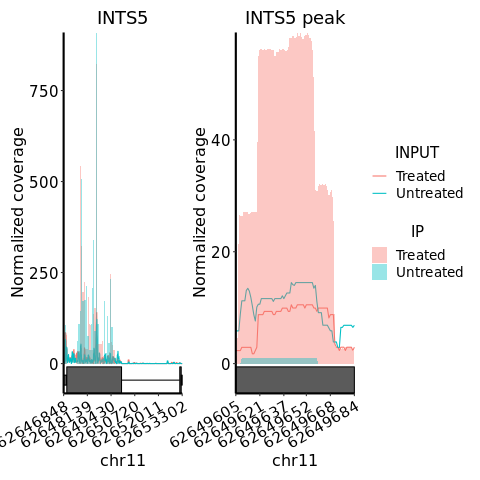

In [59]:
%%R 
p_ints5 <- p3 + p4
p_ints5

In [60]:
%%R 
ggsave('INTS5.pdf',p_ints5,width=25,height=5)

## Extract Peak Sequence 

In [91]:
import pandas as pd 

In [92]:
def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

In [93]:
def remove_intron(bed, fa):
    '''
    Remove introns for genes in given bed12 file 
    with blockSizes greater than 1
    '''
    # fa = read_fasta(fa)
    # bed = pd.read_table(bed, header=0)
    tochange = bed[bed.blockCount > 1]
    starts = [tochange.blockStarts[i].split(',')[:tochange.blockCount[i]] for i in tochange.index.tolist() ]
    sizes = [tochange.blockSizes[i].split(',')[:tochange.blockCount[i]] for i in tochange.index.tolist() ]
    for id, x, l in zip(tochange.name.tolist(), starts, sizes):
        fa[id] = ''.join([fa[id][int(i):int(i)+int(j)] for i,j in zip(x,l)])
    return fa


In [94]:
def search_fasta(fa1,fa2):
    return dict(
        [((x,fa1[x]),(y,fa2[y])) for x in fa1 for y in fa2 if fa1[x] in fa2[y] ]
    )
        

In [126]:
!samtools faidx /rumi/shams/abe/genomes/hg38/gencode.v34/GRCh38.primary_assembly.genome.fa

In [95]:
!which bedtools

/usr/bin/bedtools


In [49]:
# %%bash 
# bedtools getfasta -name -s -fi \
# /rumi/shams/abe/genomes/hg38/gencode.v34/GRCh38.primary_assembly.genome.fa \
# -bed target-genes.bed -split -fo target-genes.fa

In [96]:
!cat target-genes-sig-peaks.bed | awk -F "\t" '{print $4"\t"$2"-"$3}'

name	start-end
ENSG00000104549.12	124999289-124999338
ENSG00000185085.2	62647794-62647843
ENSG00000185085.2	62649635-62649684


In [97]:
%%bash 
bedtools getfasta -name -s -fi \
/rumi/shams/abe/genomes/hg38/gencode.v34/GRCh38.primary_assembly.genome.fa \
-bed target-genes-sig-peaks.bed -split -fo target-genes-sig-peaks.fa

In [98]:
# target_fa = read_fasta('target-genes.fa')
target_fa = read_fasta('target-genes-sig-peaks.fa')

# target_fa = dict([(key.split('::')[0]+'_peak'+str(i),target_fa[key]) for i,key in enumerate(target_fa)])

In [99]:
genome_fa = read_fasta('/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.transcripts.fa')

In [100]:
o = search_fasta(target_fa,genome_fa)

In [101]:
transcripts = dict(list({(
    o[peak][0].split('|')[1], o[peak][1]
) for peak in o.keys()}))

In [103]:
transcripts

{'ENSG00000185085.2': 'ATGCGCCGCCTGCGCTCCGCCGCTCGCGCCTCGGGCTCGGCTCGGGCTCCGGGATGTCCGCGCTGTGCGACCCTCCCGGGGCCCCAGGGCCACCTGGGCCTGCCCCGGCCACCCACGGTCCCGCGCCTCTCAGTGCTCAGGAGCTGTCCCAGGAAATCAAGGCTTTTCTGACTGGCGTAGACCCCATTCTGGGCCACCAACTCTCAGCCCGGGAACATGCTCGCTGTGGTCTTCTCCTGCTCCGTTCTTTGCCACCTGCTCGGGCTGCTGTGCTTGACCACTTGAGAGGTGTCTTTGATGAGAGTGTCCGGGCCCACCTGGCTGCCCTGGATGAAACCCCTGTGGCTGGTCCACCTCACCTCCGTCCACCTCCACCCTCTCATGTCCCTGCTGGTGGACCTGGTCTAGAGGATGTGGTTCAGGAAGTGCAGCAGGTGCTGTCTGAGTTTATCCGGGCCAACCCAAAGGCCTGGGCACCTGTGATTAGTGCATGGTCCATTGACCTCATGGGGCAACTGAGCAGCACGTACTCAGGCCAGCACCAGCGTGTTCCCCACGCTACTGGCGCTCTTAATGAACTGCTACAGCTGTGGATGGGTTGTAGGGCCACGCGTACATTAATGGACATCTATGTGCAGTGCCTCTCGGCTCTCATTGGTAGCTGCCCAGATGCGTGTGTGGATGCCTTGCTGGATACCTCTGTTCAGCATTCTCCACACTTTGACTGGGTTGTGGCACATATTGGCTCCTCTTTTCCTGGCACCATCATTTCCCGGGTTCTCTCCTGTGGCCTTAAGGACTTTTGTGTCCATGGTGGGGCTGGAGGTGGAGCTGGCAGTAGTGGTGGAAGCTCTTCTCAGACCCCCTCTACAGACCCCTTCCCTGGATCTCCTGCCATTCCTGCGGAGAAACGGGTGCCCAAGATTGCCTCAGTTGTAGGCATCCTAGGTCACCTGGCCTCCCGCCACGGAGATAGC

In [105]:
cat target-genes-sig-peaks.fa

>ENSG00000104549.12::chr8:124999289-124999338(+)
GAGTCTGGCCGGCTCTCCGTGCTCCTCTTGGTACCTCATTTTGGGGAGA
>ENSG00000185085.2::chr11:62647794-62647843(-)
GGTCAGTTTTCCATGCTGGAGTCATCGGCCGTGGCTTAAAGCCACCCAA
>ENSG00000185085.2::chr11:62649635-62649684(-)
TATCCGGGCCAACCCAAAGGCCTGGGCACCTGTGATTAGTGCATGGTCC


In [112]:
# bed = pd.read_table('target-genes.bed', header=0)
bed = pd.read_table('target-genes-sig-peaks.bed', header=0)

[
    remove_intron(
        bed[bed.iloc[:,1] == int(peak.split('::')[1].split(':')[1].split('-')[0])],
        {peak.split('::')[0]: target_fa[peak]}
    )
    for peak in target_fa
]

[{'ENSG00000104549.12': 'GAGTCTGGCCGGCTCTCCGTGCTCCTCTTGGTACCTCATTTTGGGGAGA'},
 {'ENSG00000185085.2': 'GGTCAGTTTTCCATGCTGGAGTCATCGGCCGTGGCTTAAAGCCACCCAA'},
 {'ENSG00000185085.2': 'TATCCGGGCCAACCCAAAGGCCTGGGCACCTGTGATTAGTGCATGGTCC'}]